In [1]:
try:
    # Comment out if not using colab
    from google.colab import drive
    drive.mount('/content/drive')

    # Specific for luca's computer
    %cd "/content/drive/Othercomputers/Min MacBook Pro/INFO381-GitHub"
    using_colab = True
except:
    print("Not using Google Colab")
    using_colab = False

Mounted at /content/drive
/content/drive/Othercomputers/Min MacBook Pro/INFO381-GitHub


In [2]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
from tqdm import tqdm
import random
import os
from PIL import Image

from utils import get_dataloaders

In [5]:
train_loader, test_loader = get_dataloaders(batch_size=32, split = 'both')
print(test_loader)

Running in Google Colab


In [6]:
resize_transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor()
])

train_loader.dataset.transform = resize_transform

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
model = models.resnet18(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model.load_state_dict(torch.load("models/resnet18_cnn.pth", map_location=device))
model.eval().to(device)
model.input_size = (512, 512)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [9]:
def get_random_image_by_class(dataloader, class_idx):
    for images, labels in dataloader:
        for img, label in zip(images, labels):
            if label.item() == class_idx:
                img_np = img.permute(1, 2, 0).numpy()  # convert to HWC for plotting
                return img_np, img.unsqueeze(0)  # original image, model input
    raise ValueError("Class index not found in dataset")

# Get class names from dataset
class_to_idx = train_loader.dataset.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}

# Choose one image (change to "real" if needed)
img_np, img_tensor = get_random_image_by_class(train_loader, class_idx=class_to_idx["fake"])


In [10]:
def generate_masks(N, s, p1):
    cell_size = np.ceil(np.array(model.input_size) / s).astype(int)
    up_size = ((s + 1) * cell_size).astype(int)

    grid = np.random.rand(N, s, s) < p1
    grid = grid.astype('float32')

    masks = np.empty((N, *model.input_size))

    for i in tqdm(range(N), desc='Generating masks'):
        x = np.random.randint(0, cell_size[0])
        y = np.random.randint(0, cell_size[1])
        upsampled = resize(grid[i], up_size, order=1, mode='reflect', anti_aliasing=False)
        masks[i] = upsampled[x:x + model.input_size[0], y:y + model.input_size[1]]

    masks = masks.reshape(N, 1, *model.input_size)  # (N, 1, H, W)
    return masks

In [13]:
def explain(model, inp, masks, N, p1, batch_size=100):
    with torch.no_grad():
        inp_np = inp.cpu().numpy()  # (1, 3, H, W)
        inp_np = inp_np.squeeze(0)  # -> (3, H, W)
        masked = masks * inp_np  # (N, 1, H, W) * (3, H, W) → (N, 3, H, W)

        preds = []
        for i in tqdm(range(0, N, batch_size), desc='Explaining'):
            batch = torch.from_numpy(masked[i:i+batch_size]).to(device).float()
            out = model(batch)
            probs = torch.softmax(out, dim=1).cpu().numpy()
            preds.append(probs)

        preds = np.concatenate(preds, axis=0)
        sal = preds.T @ masks.reshape(N, -1)
        sal = sal.reshape(2, *model.input_size)  # 2 classes
        sal = sal / N / p1
    return sal


In [14]:
N = 2000
s = 8
p1 = 0.5
masks = generate_masks(N, s, p1)
saliency = explain(model, img_tensor.to(device), masks, N, p1)

Explaining: 100%|██████████| 20/20 [00:04<00:00,  4.16it/s]


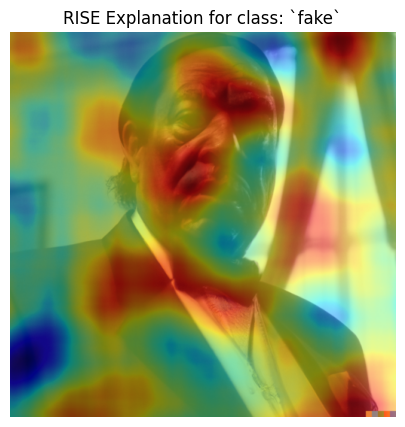

In [15]:
pred_class = torch.argmax(model(img_tensor.to(device))).item()
pred_label = idx_to_class[pred_class]

plt.figure(figsize=(10, 5))
plt.title(f"RISE Explanation for class: `{pred_label}`")
plt.imshow(img_np)
plt.imshow(saliency[pred_class], cmap='jet', alpha=0.5)
plt.axis('off')
plt.show()

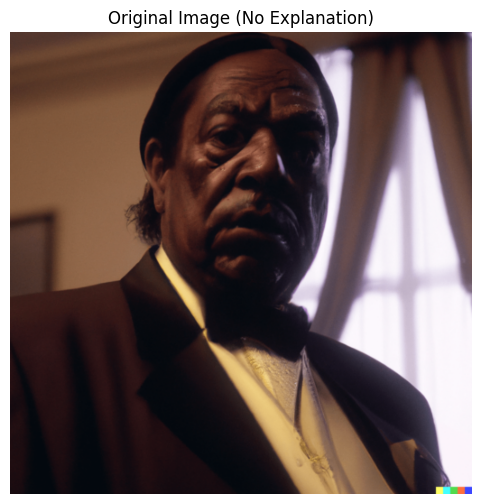

In [16]:
plt.figure(figsize=(6, 6))
plt.imshow(img_np)
plt.title("Original Image (No Explanation)")
plt.axis('off')
plt.show()